In [1]:
import torch
torch.__version__

'2.3.0+cu121'

In [2]:
!pip install git+https://github.com/huggingface/diffusers.git

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/huggingface/diffusers.git to /tmp/pip-req-build-igwxqnoa
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers.git /tmp/pip-req-build-igwxqnoa
  Resolved https://github.com/huggingface/diffusers.git to commit 3f1411767bc0f1837adb6f289713807f18599db3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached huggingface_hub-0.24.0-py3-none-any.whl.metadata (13 kB)
Using cached huggingface_hub-0.24.0-py3-none-any.whl (419 kB)
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.22.2
    Uninstalling huggingface-hub-0.22.2:
      Successfully uninstalled huggingface-hub-0.22.2


In [3]:
!pip install tensorboard tensorboardX

Defaulting to user installation because normal site-packages is not writeable


In [4]:
from huggingface_hub import snapshot_download

local_dir = "./dog"
snapshot_download(
    "diffusers/dog-example",
    local_dir=local_dir, repo_type="dataset",
    ignore_patterns=".gitattributes",
)

/home/ubuntu/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fetching 5 files: 100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 39.68it/s]


'/home/ubuntu/dog'

In [5]:
from PIL import Image

def image_grid(imgs, rows, cols, resize=256):
    assert len(imgs) == rows * cols

    if resize is not None:
        imgs = [img.resize((resize, resize)) for img in imgs]
    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

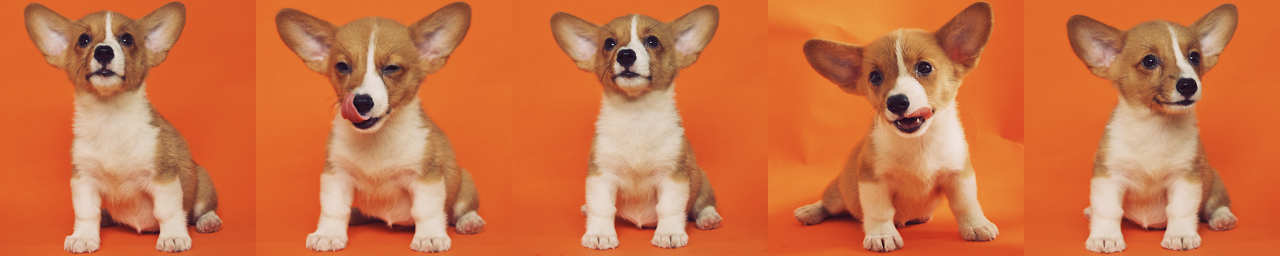

In [6]:
import glob

imgs = [Image.open(path) for path in glob.glob("./dog/*.jpeg")]
image_grid(imgs, 1, 5)

In [7]:
MODEL_NAME="stabilityai/stable-diffusion-xl-base-1.0"
INSTANCE_DIR="dog"
OUTPUT_DIR="lora-trained-xl"
VAE_PATH="madebyollin/sdxl-vae-fp16-fix"

In [8]:
!pip install accelerate

Defaulting to user installation because normal site-packages is not writeable


In [9]:
!pip install peft

Defaulting to user installation because normal site-packages is not writeable


In [11]:
! accelerate launch train_dreambooth_lora_sdxl.py \
  --pretrained_model_name_or_path=$MODEL_NAME  \
  --instance_data_dir=$INSTANCE_DIR \
  --pretrained_vae_model_name_or_path=$VAE_PATH \
  --output_dir=$OUTPUT_DIR \
  --mixed_precision="no" \
  --instance_prompt="a photo of sks dog" \
  --resolution=512 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=4 \
  --learning_rate=1e-4 \
  --report_to="tensorboard" \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --max_train_steps=500 \
  --checkpointing_steps=717

07/19/2024 12:31:29 - INFO - __main__ - Distributed environment: DistributedType.NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: no

/home/ubuntu/.local/lib/python3.12/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
{'variance_type', 'rescale_betas_zero_snr', 'thresholding', 'dynamic_thresholding_ratio', 'clip_sample_range'} was not found in config. Values will be initialized to default values.
{'use_post_quant_conv', 'latents

In [12]:
from diffusers import DiffusionPipeline

In [13]:
pipe = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16)
pipe = pipe.to("cuda")

Loading pipeline components...: 100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:54<00:00,  7.85s/it]


In [14]:
pipe.load_lora_weights("./lora-trained-xl")

In [23]:
image = pipe("A picture of a sks dog with ", num_inference_steps=25).images[0]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:08<00:00,  3.04it/s]


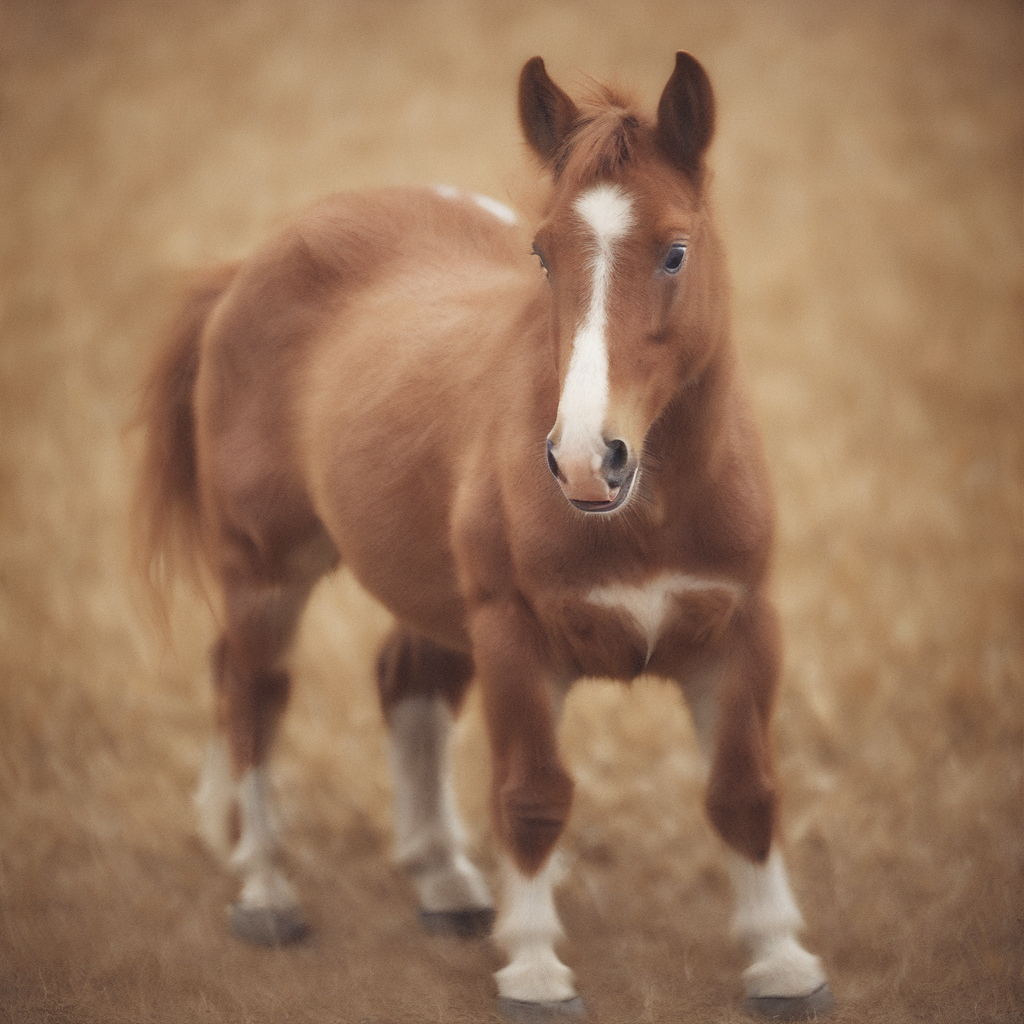

In [24]:
image